### The busiest time of day on kaggle discussions is around 15:00 UTC [(convert to my local time)](https://www.google.com/search?&q=%22UTC+14%3A45+to+my+time%22&oq=%22UTC+14%3A45+to+my+time%22)

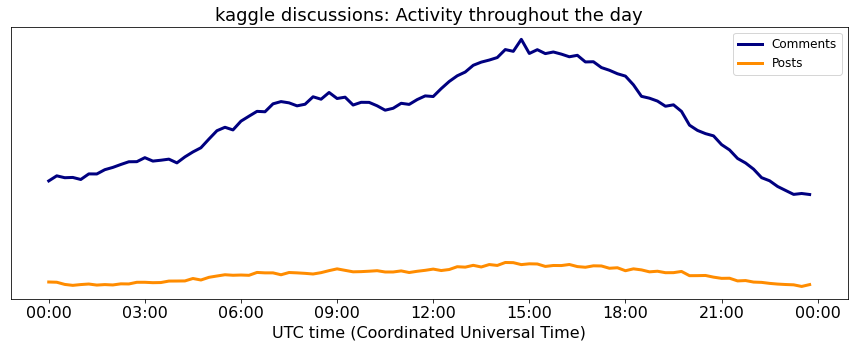

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
pd.options.mode.chained_assignment = None

# read in the dataframes
topics_df = pd.read_csv('../input/meta-kaggle/ForumTopics.csv')
messages_df = pd.read_csv('../input/meta-kaggle/ForumMessages.csv')

#convert from object to datetime64[ns]
topics_df['CreationDate'] = pd.to_datetime(topics_df['CreationDate'])
messages_df['PostDate']   = pd.to_datetime(messages_df['PostDate'])

# I shall remove topics created before 2018. Omit if you want to see all the data!
topics_since_2018   = topics_df[topics_df['CreationDate'].dt.year >= 2017] 
messages_since_2018 = messages_df[messages_df['PostDate'].dt.year >= 2017] 

# dump all data on to one very busy day!
topics_since_2018['same_day']   = topics_since_2018['CreationDate'].apply(lambda dt: dt.replace(year = 1900, month = 12, day = 1))
messages_since_2018['same_day'] = messages_since_2018['PostDate'].apply(lambda dt: dt.replace(year = 1900, month = 12, day = 1))

# group in to 15 minute blocks
topics_since_2018_histogram = topics_since_2018.groupby(pd.Grouper(key='same_day', freq="15Min")).count()
messages_since_2018_histogram = messages_since_2018.groupby(pd.Grouper(key='same_day', freq="15Min")).count()

# what is the busiest time of day? (uncomment to see "Name")
# messages_since_2018_histogram.loc[messages_since_2018_histogram['Id'].idxmax()]

# now make a plot:
fig, ax = plt.subplots(figsize=(15, 5))
time_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(time_format)
plt.xticks(fontsize=16)
plt.yticks([])
plt.plot(messages_since_2018_histogram['Id'], color='navy', lw=3, label='Comments')
plt.plot(topics_since_2018_histogram['Id'], color='darkorange', lw=3, label='Posts')
plt.xlabel('UTC time (Coordinated Universal Time)',fontsize=16)
plt.title('kaggle discussions: Activity throughout the day',fontsize=18)
plt.legend(loc="upper right",fontsize=12)
plt.show()

## A little bit of analysis
We can see that the publication of posts or *Topics* is fairly constant throughout the day. However, we can see what appear to be two peaks within the curve of the number of Comments. What we shall now do is to make a model of this Comments curve by fitting two [Gaussian functions](https://en.wikipedia.org/wiki/Gaussian_function), using the [curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) routine from [SciPy](https://docs.scipy.org/doc/):

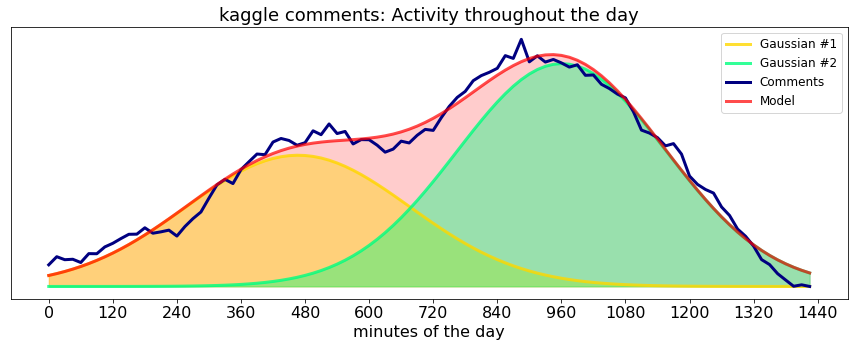

In [2]:
from scipy.optimize import curve_fit

x = list(range(len(messages_since_2018_histogram)))
minutes = 15        # 15 minute blocks
x = [i * minutes for i in x]
y = messages_since_2018_histogram['Id']
y = y - y.min()    # remove the basline from the y values

def Gaussian(x,mu,sigma,A):
    return A*np.exp(-0.5 * ((x-mu)/sigma)**2)

def bimodal(x,mu_1,sigma_1,A_1,mu_2,sigma_2,A_2):
    return Gaussian(x,mu_1,sigma_1,A_1) + Gaussian(x,mu_2,sigma_2,A_2)

initial_guess=(500, 200 ,6000, 900, 200 ,7500)
parameters,covariance=curve_fit(bimodal,x,y,initial_guess)
sigma=np.sqrt(np.diag(covariance))

# now make a plot:
import matplotlib.ticker as plticker
fig, ax = plt.subplots(figsize=(15, 5))
loc = plticker.MultipleLocator(base=120) # print ticks every 120 minutes
ax.xaxis.set_major_locator(loc)
plt.xticks(fontsize=16)
plt.yticks([])

# plot gaussian #1
plt.plot(x,Gaussian(x,parameters[0],parameters[1],parameters[2]),color='gold',lw=3,label='Gaussian #1', alpha=0.8)
# plot gaussian #2
plt.plot(x,Gaussian(x,parameters[3],parameters[4],parameters[5]),color='springgreen',lw=3,label='Gaussian #2', alpha=0.8)

# fill under the Gaussians
BM = bimodal(x,*parameters)
G1 = Gaussian(x,parameters[0],parameters[1],parameters[2])
G2 = Gaussian(x,parameters[3],parameters[4],parameters[5])
plt.fill_between(x,BM,color='red',        alpha=0.2)
plt.fill_between(x,G1,color='gold',       alpha=0.4)
plt.fill_between(x,G2,color='springgreen',alpha=0.4)

# plot the Comments curve
plt.plot(x,y, color='navy', lw=3, label='Comments')
# plot the two gaussians together as the model
plt.plot(x,bimodal(x,*parameters),color='red',lw=3,label='Model', alpha=0.7)

plt.xlabel('minutes of the day',fontsize=16)
plt.title('kaggle comments: Activity throughout the day',fontsize=18)
plt.legend(loc="upper right",fontsize=12)
plt.show()

The parameters for these two Gaussians are:

In [3]:
import datetime
from datetime import timedelta

g1_pt    = str(datetime.timedelta(minutes=parameters[0])).split('.', 2)[0]
g1_max   = int(parameters[2])
g1_sigma = int(parameters[1])
g2_pt    = str(datetime.timedelta(minutes=parameters[3])).split('.', 2)[0]
g2_max   = int(parameters[5])
g2_sigma = int(parameters[4])

# create a table
import plotly.figure_factory as ff
data_matrix = [['Parameter',        'Gaussian #1', 'Gaussian #2'],
               ['Peak time (UTC)',        g1_pt, g2_pt],
               ['Peak height',            g1_max, g2_max],
               ['Sigma (minutes)',         g1_sigma, g2_sigma]]
fig = ff.create_table(data_matrix)
fig.show()

We can clearly see the two curves, both have a similar [full width at half maximum (FWHM)](https://en.wikipedia.org/wiki/Full_width_at_half_maximum) of approximately 8 hours. The peak of the second curve is approximately 1.7 times higher than the peak of the first curve, and the peaks are separated by a period of about 8 hours.

### What does the world look like at those times of day?

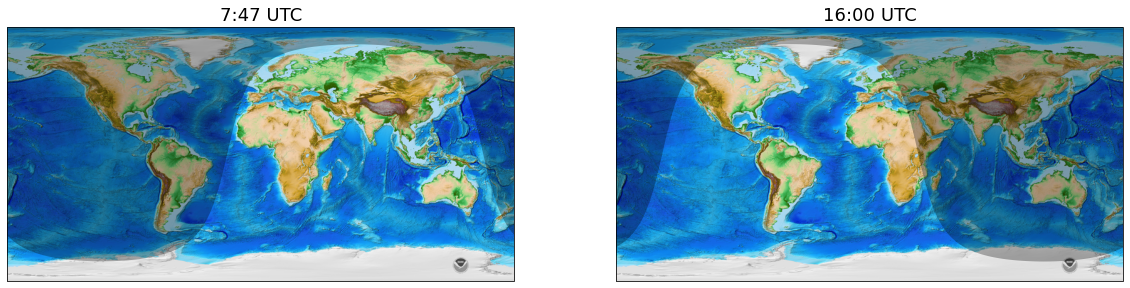

In [4]:
import datetime
import cartopy.crs as ccrs
from cartopy.feature.nightshade import Nightshade

fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
date = datetime.datetime(1564, 2, 15, 7, 47, 0, 0)
ax.set_title('7:47 UTC', fontsize = 18)
# the Cartopy stock background image (shadedrelief)
#ax.stock_img()
# the etopo background image from the old Matplotlib Basemap Toolkit
img = plt.imread('../input/global-earth-map-images/etopo.png')
img_extent = (-180, 180, -90, 90)
ax.imshow(img, origin='upper', extent=img_extent, transform=ccrs.PlateCarree())
ax.add_feature(Nightshade(date, alpha=0.3))

ax = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
date = datetime.datetime(1564, 2, 15, 16, 0, 0, 0)
ax.set_title('16:00 UTC', fontsize = 18)
# the Cartopy stock background image (shadedrelief)
#ax.stock_img()
# the etopo background image from the old Matplotlib Basemap Toolkit
img_extent = (-180, 180, -90, 90)
ax.imshow(img, origin='upper', extent=img_extent, transform=ccrs.PlateCarree())
ax.add_feature(Nightshade(date, alpha=0.3))

plt.show();

**Notes**: 
1. I have arbitrarily used data from 2017 up to the up until the present time. This can easily be changed in the script. I have used blocks of 15 minutes; this too can very easily be changed in the script.
2. On the world maps, for the day of the year I have chosen the birthdate of [Galileo Galilei](https://en.wikipedia.org/wiki/Galileo_Galilei) (15 February 1564) to show the [terminator line](https://en.wikipedia.org/wiki/Terminator_%28solar%29).